In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_dir = Path("data/huge_stock_market_dataset/")
results_dir = Path("results")

In [3]:
ts_info = pd.read_csv(dataset_dir / "selected.csv")
ts_info["ts_id"] = ts_info.index
results = []
for results_type in ("pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"):
    for model in ("LSTM", "TCN", "cbr"):
        df = pd.read_csv(results_dir / f"{results_type}_{model}.csv")
        df["model"] = model
        df["results_type"] = results_type
        results.append(df)
results = pd.concat(results)
results["model"].replace("cbr", "CatBoostRegressor", inplace=True)
results["results_type"].replace(["pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"],
                                ["train set", "QuantGAN synthetic data", "FourierFlow synthetic data", "RealNVP synthetic data", "TTS GAN synthetic data"], 
                                inplace=True)
results

,train,val,model,results_type
0,0.209393,0.494530,LSTM,train set
1,0.291278,0.790302,LSTM,train set
2,0.118129,0.646071,LSTM,train set
3,0.175964,0.924557,LSTM,train set
4,0.156720,0.723230,LSTM,train set
...,...,...,...,...
19,0.717771,0.434187,CatBoostRegressor,TTS GAN synthetic data
20,0.289151,0.289151,CatBoostRegressor,TTS GAN synthetic data
21,1.292195,1.028938,CatBoostRegressor,TTS GAN synthetic data
22,2.658689,3.180226,CatBoostRegressor,TTS GAN synthetic data


In [4]:
results_agg = results.groupby(by=["model", "results_type"], axis=0).agg(train=("train", "mean"), val=("val", "mean"))
results_agg

train       val
model             results_type                                  
CatBoostRegressor FourierFlow synthetic data  0.537001  0.466452
                  QuantGAN synthetic data     0.658691  0.550510
                  RealNVP synthetic data      0.535545  0.478840
                  TTS GAN synthetic data      0.819479  0.704444
                  train set                   0.590868  0.517799
LSTM              FourierFlow synthetic data  0.445155  0.510441
                  QuantGAN synthetic data     0.667470  0.546263
                  RealNVP synthetic data      0.277236  0.548969
                  TTS GAN synthetic data      0.830979  0.699460
                  train set                   0.217522  0.634200
TCN               FourierFlow synthetic data  0.441246  0.501023
                  QuantGAN synthetic data     0.667294  0.546493
                  RealNVP synthetic data      0.359338  0.522067
                  TTS GAN synthetic data      0.833060  0.701539
                  train set                   0.360154  0.577068

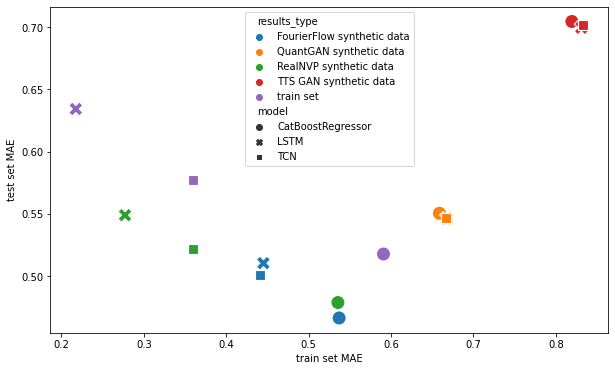

In [11]:
fig, ax = plt.subplots(1, figsize=(10, 6))
# sns.scatterplot(data=results_agg[results_agg.index.get_level_values(1) != "TTS GAN synthetic data"], x="train", y="val", hue="results_type", style="model", s=200, ax=ax)
sns.scatterplot(data=results_agg, x="train", y="val", hue="results_type", style="model", s=200, ax=ax)
ax.set_xlabel("train set MAE")
ax.set_ylabel("test set MAE")
plt.show()

<AxesSubplot:xlabel='model', ylabel='val'>

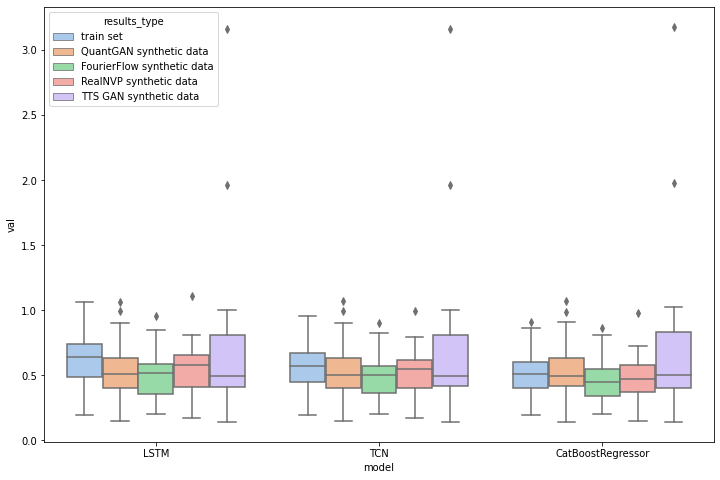

In [13]:
fig, ax = plt.subplots(1, figsize=(12, 8))
# sns.boxplot(data=results[results.results_type != "TTS GAN synthetic data"], x="model", y="val", hue="results_type", palette="pastel", ax=ax)
sns.boxplot(data=results, x="model", y="val", hue="results_type", palette="pastel", ax=ax)

# Gains

In [7]:
pure = results[results.results_type == "train set"]
gains = None
for synth_rt in (x for x in results.results_type.unique() if x != "train set"):
    synth_df = results[results.results_type == synth_rt]
    gain = (pure.groupby([pure.index, "model"]).mean() - synth_df.groupby([synth_df.index, "model"]).mean()) / pure.groupby([pure.index, "model"]).mean() * 100
    gain.index, gain["model"] = gain.index.get_level_values(0), gain.index.get_level_values(1)
    synth_rt = synth_rt.split(' ')[0]
    gain.rename(columns={"train": f"train_{synth_rt}", "val": f"val_{synth_rt}"}, inplace=True)
    gain["ts_id"] = gain.index
    if gains is None:
        gains = gain
    else:
        gains = gains.merge(gain, on=["model", "ts_id"])

gains = gains.merge(ts_info, on="ts_id")
gains

,train_QuantGAN,val_QuantGAN,model,ts_id,train_FourierFlow,val_FourierFlow,train_RealNVP,val_RealNVP,train_TTS,val_TTS,filename,length,uptrending_rate
0,-18.226153,-1.709593,CatBoostRegressor,0,-0.063664,1.002655,5.063140,-5.242012,-12.650232,-12.979911,opgnw.us.txt,444,0.388262
1,-152.649645,13.132405,LSTM,0,19.010354,-1.542672,71.264994,-13.811995,-133.137142,6.840798,opgnw.us.txt,444,0.388262
2,-123.598831,10.085446,TCN,0,29.537066,-3.044380,65.688582,-20.718233,-109.711547,2.302369,opgnw.us.txt,444,0.388262
3,-50.302197,-40.888869,CatBoostRegressor,1,5.164977,3.191153,2.767372,-3.617401,-12.078030,-2.221954,dare.us.txt,905,0.431416
4,-157.582247,-25.811443,LSTM,1,-5.521431,-7.343942,64.788962,-2.168396,-91.328986,9.659256,dare.us.txt,905,0.431416
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-276.270747,14.784921,LSTM,22,-227.517521,23.187990,-181.828715,30.738481,-1239.330775,-198.022381,gfi.us.txt,6686,0.454899
68,-56.753009,5.732385,TCN,22,-32.001766,14.284509,-15.839381,24.254213,-458.208522,-229.733069,gfi.us.txt,6686,0.454899
69,-21.007903,-15.585407,CatBoostRegressor,23,8.084282,5.511515,4.426795,0.829428,-163.301055,-150.679952,hig.us.txt,5514,0.506258
70,-102.305065,-8.283677,LSTM,23,-39.708370,7.881074,-39.648439,5.436428,-342.313286,-132.678989,hig.us.txt,5514,0.506258


In [8]:
gains.groupby(["model"]).mean().drop(columns=["ts_id", "length", "uptrending_rate"])

,train_QuantGAN,val_QuantGAN,train_FourierFlow,val_FourierFlow,train_RealNVP,val_RealNVP,train_TTS,val_TTS
model,,,,,,,,
CatBoostRegressor,-11.641542,-5.042784,8.653427,9.526497,9.007658,6.087829,-37.219024,-34.872037
LSTM,-271.533069,13.899258,-145.007789,18.820439,-32.544525,11.503603,-351.310962,-13.997123
TCN,-90.215674,6.188218,-21.782351,12.920550,3.751825,7.755158,-123.759434,-23.344923


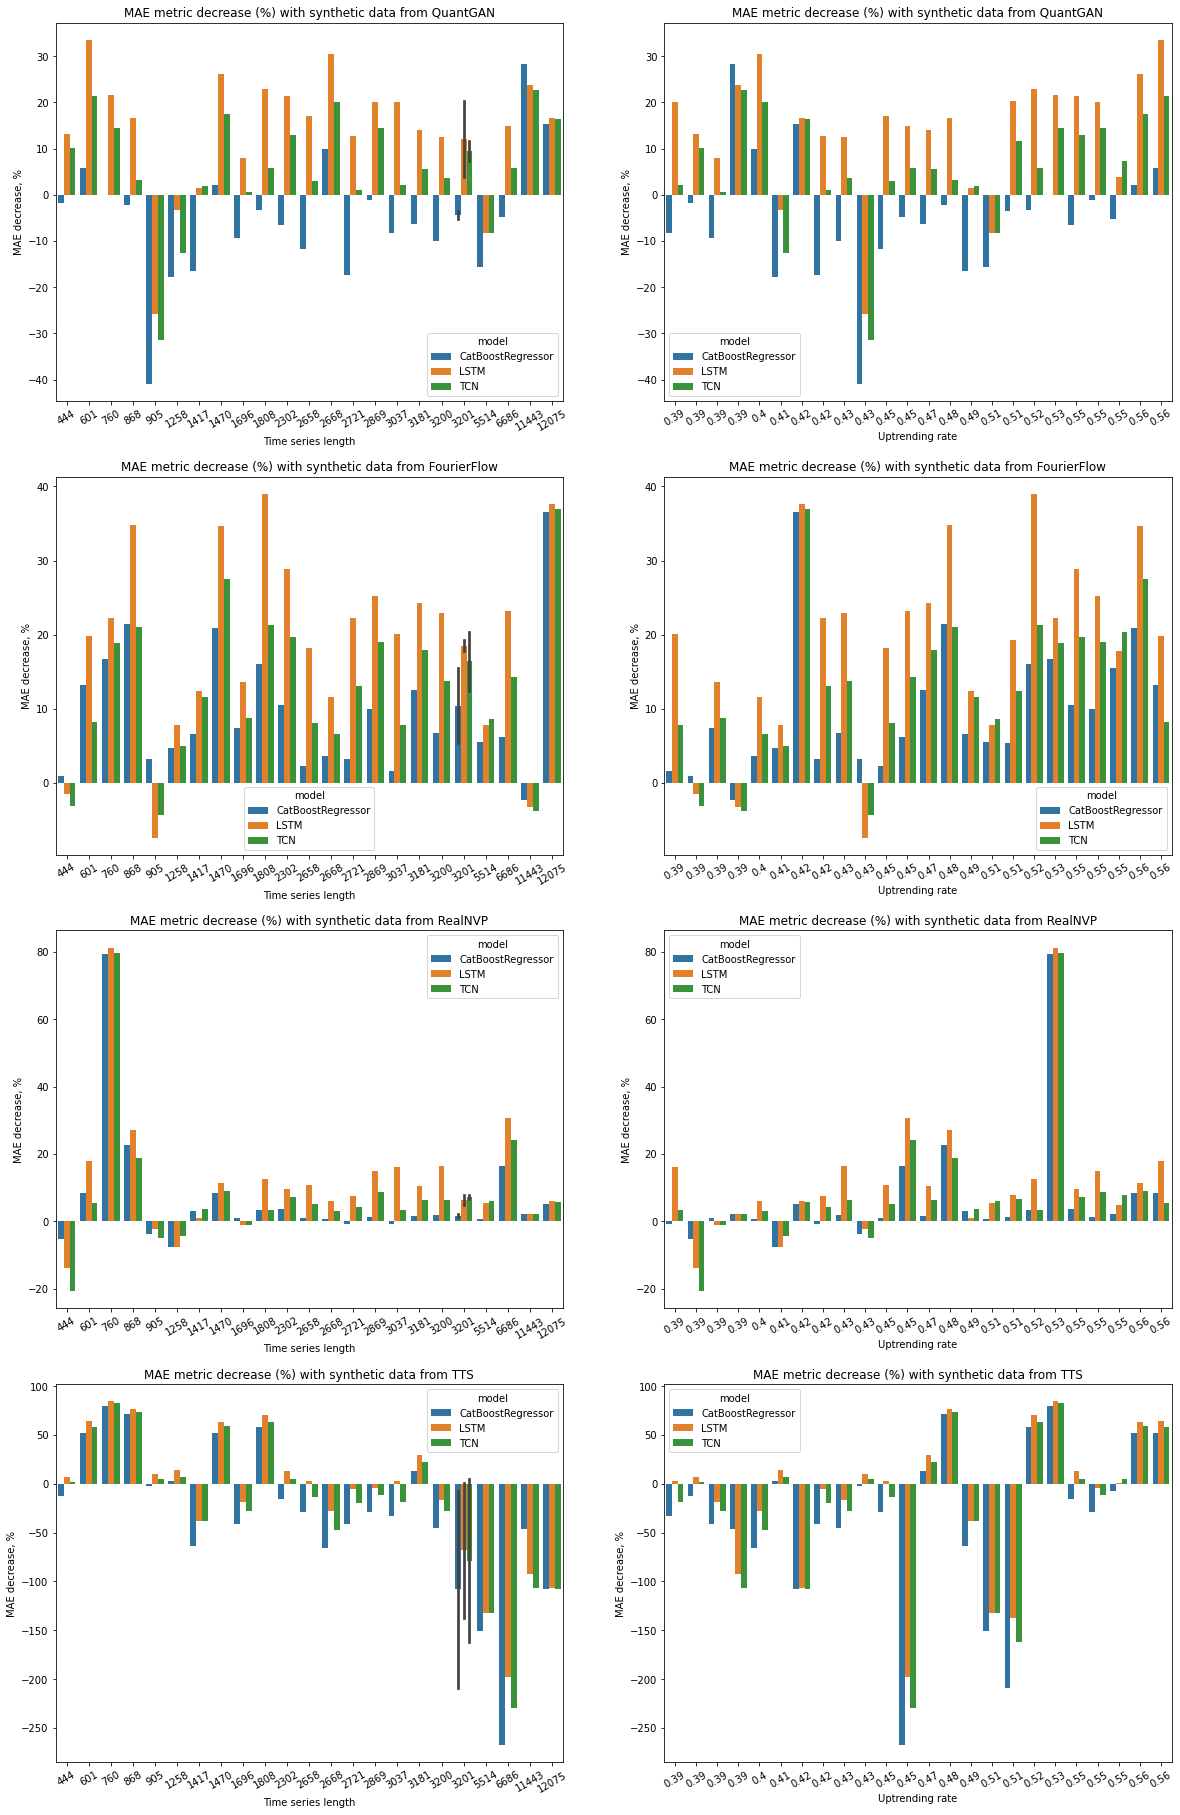

In [14]:
synth_models = ["QuantGAN", "FourierFlow", "RealNVP", "TTS"]
fig, axs = plt.subplots(len(synth_models), 2, figsize=(20, 8 * len(synth_models)))

for i in range(len(synth_models)):
    sns.barplot(data=gains, x="length", y=f"val_{synth_models[i]}", hue="model", ax=axs[i][0])
    axs[i][0].set_xlabel("Time series length")
    axs[i][0].set_xticklabels(sorted(gains["length"].unique()), rotation=30)
    axs[i][0].set_ylabel("MAE decrease, %")

    sns.barplot(data=gains, x="uptrending_rate", y=f"val_{synth_models[i]}", hue="model", ax=axs[i][1])
    axs[i][1].set_xlabel("Uptrending rate")
    axs[i][1].set_xticklabels(map(lambda x: round(x, 2), sorted(gains.uptrending_rate.unique())), rotation=30)
    axs[i][1].set_ylabel("MAE decrease, %")

    for j in range(2): axs[i][j].set_title(f"MAE metric decrease (%) with synthetic data from {synth_models[i]}")
    
plt.show()

In [15]:
length_intervals = [0, 1000, 5000, 13000]
temp = []
for i in range(1, len(length_intervals)):
    temp.append(gains[((gains.length > length_intervals[i - 1]) & (gains.length < length_intervals[i]))]\
        .groupby("model").mean())
    temp[- 1]["length"] = f"{length_intervals[i - 1]}-{length_intervals[i]}"
pd.concat(temp).drop(columns=["uptrending_rate", "ts_id"])

,train_QuantGAN,val_QuantGAN,train_FourierFlow,val_FourierFlow,train_RealNVP,val_RealNVP,train_TTS,val_TTS,length
model,,,,,,,,,
CatBoostRegressor,-22.058187,-7.847260,8.136345,11.105235,26.837460,20.301911,35.723086,37.641717,0-1000
LSTM,-284.017260,11.801977,-72.880943,13.574995,56.825435,22.057138,-64.592747,48.484940,0-1000
TCN,-132.127939,3.514659,5.531411,8.140774,55.298656,15.592039,-18.614384,44.483157,0-1000
CatBoostRegressor,-12.327676,-6.994148,7.978144,8.480814,3.607988,1.345488,-36.376160,-30.203634,1000-5000
LSTM,-316.282562,15.182759,-191.471620,21.227620,-56.039774,8.081278,-426.270442,-3.258764,1000-5000
TCN,-93.240632,6.297409,-34.240946,14.215481,-9.369710,4.658744,-132.915229,-13.704166,1000-5000
CatBoostRegressor,3.952266,5.780425,11.832091,11.474384,6.969165,6.104006,-131.557399,-143.020743,5000-13000
LSTM,-88.117231,11.707726,-60.926978,16.350316,-56.149789,11.145408,-428.610680,-132.368550,5000-13000
TCN,-26.481749,9.120702,-9.204821,14.039277,-11.475958,9.570609,-220.856518,-144.282863,5000-13000
